https://www.kaggle.com/competitions/nlp-getting-started

In [55]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN, Dense, Activation, Dropout, Embedding, Bidirectional
from sklearn import preprocessing
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk

In [24]:
home_dir = "."

Load train data

In [25]:
data = pd.read_csv(home_dir + '/train.csv')

Study the data

In [26]:
num_lines, num_cols = data.shape
text_cols = ['keyword', 'location', 'text']
# Dataset length:
print("num of lines", num_lines)
# Lets count nulls
print("counts:")
print(data.count())

num of lines 7613
counts:
id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64


In [27]:
print('describe numerical columns:')
print(data.describe())
print('target')
print(data['target'].value_counts())

describe numerical columns:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
target
0    4342
1    3271
Name: target, dtype: int64


In [28]:
print('string lengths in text columns:')
for text_col in text_cols:
    print("describing", text_col)
    print("max num of symbols:")
    print(data[text_col].apply(lambda x : len(str(x))).max())
    print("max num of words:")
    print(data[text_col].apply(lambda x : len(str(x).split(" "))).max())

string lengths in text columns:
describing keyword
max num of symbols:
21
max num of words:
1
describing location
max num of symbols:
49
max num of words:
11
describing text
max num of symbols:
157
max num of words:
54


In [29]:
data["location"].value_counts()

USA                 104
New York             71
United States        50
London               45
Canada               29
                   ... 
Saline, MI            1
Wanderlust            1
2,360 miles away      1
SEA Server            1
Arvada, CO            1
Name: location, Length: 3341, dtype: int64

In [30]:
data["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Study symbols

In [31]:
def spec_symbols(st):
    res = [""]
    # sequences of numbers and symbols
    for c in st:
        if not c.isalpha():
            res[-1] += c
        else:
            if len(res[-1]) > 0:
                res.append("")
    if len(res[-1]) == 0:
        res.pop()
    return np.array(res)

In [32]:
for text_col in text_cols:
    symbols = np.array(data[text_col].apply(lambda x : spec_symbols(str(x))))
    fileout = open(home_dir + '/' + text_col + "_sym.txt", "w", encoding="utf-8")
    for sym in np.unique(np.concatenate(symbols)):
        print(sym, file=fileout)

- keywords contain symbol "%20", they are probably decoded
- Text contains a lot of non-alphanumeric symbols
- Text also contains links, references to other twitter users (like @user), and hashtags

*We want to get rid of links, references, and non-alpha symbols.*
*Also we will remove stop-words and make lemmatization*


Prepare the data:

In [33]:
def prepare_data(data):
    stopwords = nltk.corpus.stopwords.words('english')
    lemm = nltk.stem.WordNetLemmatizer()
    
    data_p = data
    # Let's fill NaNs with empty strings
    data_p = data_p.fillna("")
    
    # This data may be useful some day if we try to implement more complex model:
    data_p['has_twitter_links'] = data_p["text"].apply(lambda x : 'http://t.co/' in str(x))
    data_p['has_references'] = data_p["text"].apply(lambda x : re.search(r'@[a-z, A-Z]', x) is not None)
    
    # Delete all links
    text_no_links = data_p["text"].apply(lambda x : " ".join(filter(lambda y : (( not 'http://' in y) and ( not 'https://' in y)), str(x).split(" "))))
    # Delete all refs
    text_no_refs = text_no_links.apply(lambda x : " ".join(filter(lambda y : (not (len(y) > 0 and y[0] == "@")), str(x).split(" "))))
    # Delete all stopwords
    text_no_stopwords = text_no_refs.apply(lambda x : " ".join(filter(lambda y : (y.lower() not in stopwords), str(x).split(" "))))
    # Lemmitize
    text_lemmatized = text_no_stopwords.apply(lambda x : " ".join([lemm.lemmatize(y) for y in str(x).split(" ")]))
    # Save
    data_p["text"] = text_lemmatized
    
    # Decode keywords
    keywords_decoded = data_p["keyword"].apply(lambda x : " ".join(str(x).split("%20")))
    data_p['keyword'] = keywords_decoded

    # I do no want to use digits here so I will delete them along with all other characters
    # And I'll also make all the letters lowercase
    for col in ["text", "keyword", "location"]:
        data_p[col] = data_p[col].apply(lambda x : ("".join([c for c in str(x) if (c.isalpha() or c == ' ')])).lower() if str(x) != "nan" else "")
    data_p["id"] = data["id"]
    return data_p

In [34]:
data_processed = prepare_data(data)

In [35]:
data_processed["more_text"] = data_processed["keyword"] + " " + data_processed["text"]

In [36]:
# Good to know max num of words - for padding
print("Num of words", data_processed["text"].apply(lambda x : len(x.split(" "))).max())

Num of words 51


Split the data

In [37]:
# Split dataset
xtrain, xvalid, ytrain, yvalid = train_test_split(
    data_processed['more_text'], data_processed['target'], stratify=data_processed['target'],
    test_size=0.2, shuffle=True)

In [38]:
# Using keras tokenizer

token = text.Tokenizer(num_words=None, oov_token="<OOV>")
token.fit_on_texts(list(xtrain) + list(xvalid))

# Create sequences
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

max_len = 54
#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

**Trying Simple RNN**

In [39]:
# Creating a model

model = Sequential([
    Embedding(len(word_index) + 1, 50, input_length = max_len),
    SimpleRNN(units=25),
    Dense(1, activation='sigmoid')
])

# We may use early stopping to avoid overfitting
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# I have used early stopping before. Looking at the plot I have realised that it is better to 
# run fitting for one epoch =)
history = model.fit(
    xtrain_pad, ytrain,
    validation_data=(xvalid_pad, yvalid),
    epochs=1,
    verbose=0
)

In [41]:
history_df = pd.DataFrame(history.history)

#history_df.loc[:, ['loss', 'val_loss']].plot()
#history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))


Best Validation Loss: 0.5002
Best Validation Accuracy: 0.7571


Now we use all data to train the model

In [42]:
data_all = data_processed.sample(frac=1)

xall, yall = data_all['more_text'], data_all['target']

xall_seq = token.texts_to_sequences(xall)


#zero pad the sequences
xall_pad = sequence.pad_sequences(xall_seq, maxlen=max_len)

#model
model = Sequential([
    Embedding(len(word_index) + 1, 50, input_length = max_len),
    SimpleRNN(units=25),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    xall_pad, yall,
    epochs=1,
)

238/238 [==============================] - 5s 21ms/step - loss: 0.5438 - accuracy: 0.7176


Apply model to make the first submission!

In [43]:
# Apply model

test_data = pd.read_csv(home_dir + '/test.csv')

test_data_processed = prepare_data(test_data)
test_data_processed["more_text"] = test_data_processed["keyword"] + " " + test_data_processed["text"]

xtest = test_data_processed['more_text']
xtest_seq = token.texts_to_sequences(xtest)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

scores = model.predict(xtest_pad) > 0.5  # 0.5 is a threshold
test_data_processed['target'] = scores.astype(int)
result = test_data_processed[["id", "target"]]
result.to_csv(home_dir + "/submission.csv", index=False)

**LSTM  with GLoVe** 

In [44]:
# Load embedding index
embeddings_index = {}
f = open(home_dir + '/glove.twitter.27B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

1193514it [01:12, 16552.61it/s]


In [45]:
# Create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector   

100%|████████████████████████████████████████████████████████████████████████| 14904/14904 [00:00<00:00, 346841.33it/s]


In [46]:
# Create and compile model

model = Sequential([
    Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length = max_len, trainable=False),
    LSTM(50, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

# We may use early stopping to avoid overfitting

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
history = model.fit(
    xtrain_pad, ytrain,
    validation_data=(xvalid_pad, yvalid),
    epochs=10,
    callbacks=[early_stopping],
    verbose=0
)

Best Validation Loss: 0.4365
Best Validation Accuracy: 0.8181


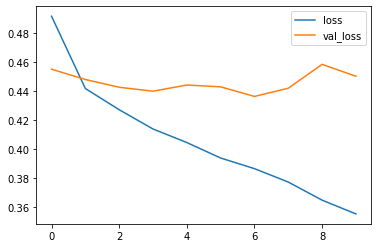

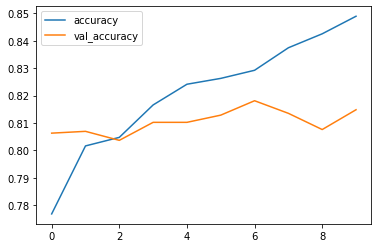

In [48]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

Train using all data

In [49]:
model = Sequential([
    Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length = max_len, trainable=False),
    LSTM(50, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    xall_pad, yall,
    epochs=8
)

Epoch 1/8
238/238 [==============================] - 19s 79ms/step - loss: 0.4884 - accuracy: 0.7763
Epoch 2/8
238/238 [==============================] - 19s 79ms/step - loss: 0.4461 - accuracy: 0.7998
Epoch 3/8
238/238 [==============================] - 19s 79ms/step - loss: 0.4340 - accuracy: 0.8091
Epoch 4/8
238/238 [==============================] - 20s 85ms/step - loss: 0.4194 - accuracy: 0.8141
Epoch 5/8
238/238 [==============================] - 19s 80ms/step - loss: 0.4112 - accuracy: 0.8179
Epoch 6/8
238/238 [==============================] - 19s 79ms/step - loss: 0.3941 - accuracy: 0.8302
Epoch 7/8
238/238 [==============================] - 21s 86ms/step - loss: 0.3890 - accuracy: 0.8265
Epoch 8/8
238/238 [==============================] - 21s 87ms/step - loss: 0.3868 - accuracy: 0.8300


Apply model to submit results

In [50]:
# Apply model

scores = model.predict(xtest_pad) > 0.5  # 0.5 is a threshold
test_data_processed['target'] = scores.astype(int)
result = test_data_processed[["id", "target"]]
result.to_csv(home_dir + "/submission_lstm.csv", index=False)

**GRU with GLoVe** 

In [51]:
# Create and compile model

model = Sequential([
    Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length = max_len, trainable=False),
    SpatialDropout1D(0.3),
    GRU(50),
    Dense(1, activation='sigmoid')
])

# We may use early stopping to avoid overfitting

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(
    xtrain_pad, ytrain,
    validation_data=(xvalid_pad, yvalid),
    epochs=10,
    callbacks=[early_stopping],
    verbose=0
)

Best Validation Loss: 0.4406
Best Validation Accuracy: 0.8129


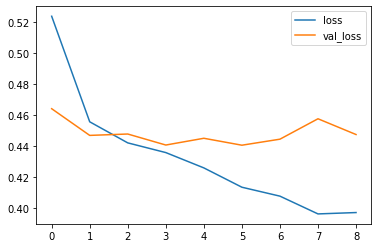

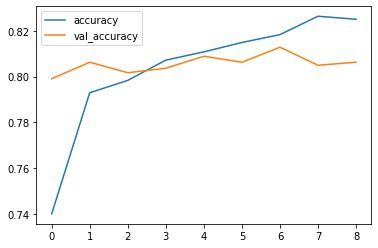

In [53]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

**Bi-Directional LSTM**

In [56]:
# Create and compile model

model = Sequential([
    Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length = max_len, trainable=False),
    Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)),
    Dense(1, activation='sigmoid')
])

# We may use early stopping to avoid overfitting

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
history = model.fit(
    xtrain_pad, ytrain,
    validation_data=(xvalid_pad, yvalid),
    epochs=10,
    callbacks=[early_stopping],
    verbose=0
)

Best Validation Loss: 0.4438
Best Validation Accuracy: 0.8050


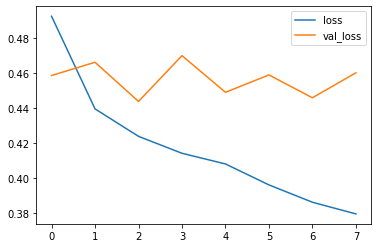

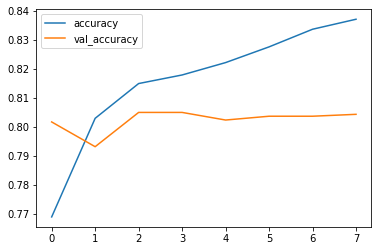

In [58]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))